Topic modelling for instagram project


In [3]:
import nltk
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Darren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Import Dataset instagram
df = pd.read_csv("table-spcasingapore.csv")
print(df.columns.unique())
df.head()
#number of group 4

Index(['Unnamed: 0', 'ID', 'Post_URL', 'Img_URL', 'Likes', 'Owner', 'Text',
       'Date'],
      dtype='object')


,Unnamed: 0,ID,Post_URL,Img_URL,Likes,Owner,Text,Date
0,57,B8qnibwnZXy,http://instagram.com/p/B8qnibwnZXy,https://scontent-xsp1-1.cdninstagram.com/v/t51...,1343,1314535851,An SPCA officer rescued this kitten from a sho...,17/2/2020 19:13
1,55,B8tbr4iHjQY,http://instagram.com/p/B8tbr4iHjQY,https://scontent-xsp1-1.cdninstagram.com/v/t51...,639,1314535851,WOUNDED CAT’S AMAZING RECOVERY [GRAPHIC] Godfa...,18/2/2020 21:27
2,561,B12VAq-B2_h,http://instagram.com/p/B12VAq-B2_h,https://scontent-xsp1-1.cdninstagram.com/v/t51...,566,197651475,Reposted by @spcasingapore APPEAL FOR INFORMAT...,1/9/2019 8:42
3,48,B8yBY3bnZyn,http://instagram.com/p/B8yBY3bnZyn,https://scontent-xsp1-1.cdninstagram.com/v/t51...,564,1314535851,SPCA VOLUNTEER SPOTLIGHT — “I work from 6am to...,20/2/2020 16:14
4,323,B4TBFc2lm9_,http://instagram.com/p/B4TBFc2lm9_,https://scontent-xsp1-1.cdninstagram.com/v/t51...,392,496751601,"At around 12.15am, @spcasingapore alerted me t...",1/11/2019 5:09


In [6]:
# Convert to list
data = df.Text.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

#remove for instagram
data = [re.sub('#spcasingapore', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<ipython-input-6-85daae7ae2a8>:5: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-6-85daae7ae2a8>:8: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
import en_core_web_sm


# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 3), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 4), (39, 1)]]


In [12]:
from gensim.models import CoherenceModel
def calculate_coherencescore_for_topics(corpus_vect,dictionary,processed_docs,n=10):
    score = []
    for i in range(1,11):
        ldamodel = gensim.models.ldamodel.LdaModel(corpus_vect, num_topics = i, id2word=dictionary, passes=25, random_state= 0)
        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=ldamodel, texts=processed_docs, dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        score.append(coherence_lda)
    return score
    
score = calculate_coherencescore_for_topics(corpus,id2word,data_lemmatized)

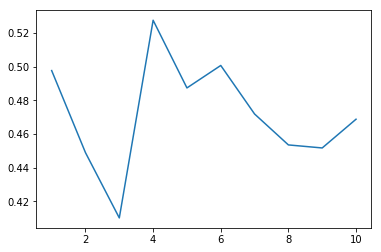

In [13]:
import matplotlib.pyplot as plt
import numpy as np


plt.plot([1,2,3,4,5,6,7,8,9,10],score)
plt.show()

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\Darren\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.103699  0.139605       1        1  36.458126
2      0.060454 -0.132866       2        1  24.720598
1      0.063117 -0.027467       3        1  19.819508
3     -0.227269  0.020729       4        1  19.001762, topic_info=     Category        Freq                 Term       Total  loglift  logprob
term                                                                        
50    Default   77.000000                  cat   77.000000  30.0000  30.0000
169   Default  234.000000                  dog  234.000000  29.0000  29.0000
1210  Default   54.000000      catsofinstagram   54.000000  28.0000  28.0000
1082  Default   60.000000             adoption   60.000000  27.0000  27.0000
296   Default   31.000000      catsofsingapore   31.000000  26.0000  26.0000
1235  Default   35.000000             dogwalke   35.000000  25.0000  25.0000
1044  Default   29.000000                smile   29.000000  24.0000  24.0000
1340  Default   27.000000                 meow   27.000000  23.0000  23.0000
443   Default   27.000000                  pet   27.000000  22.0000  22.0000
1212  Default   23.000000         splootingcat   23.000000  21.0000  21.0000
300   Default   22.000000                flute   22.000000  20.0000  20.0000
1093  Default   25.000000               spotty   25.000000  19.0000  19.0000
292   Default  149.000000        adoptdontshop  149.000000  18.0000  18.0000
293   Default   20.000000                   be   20.000000  17.0000  17.0000
1211  Default   20.000000  singaporecats_sgcat   20.000000  16.0000  16.0000
420   Default   37.000000                 play   37.000000  15.0000  15.0000
275   Default   19.000000                sgcat   19.000000  14.0000  14.0000
339   Default   45.000000                 home   45.000000  13.0000  13.0000
1309  Default   15.000000      flutethesealion   15.000000  12.0000  12.0000
566   Default   15.000000              weekend   15.000000  11.0000  11.0000
159   Default   56.000000                 come   56.000000  10.0000  10.0000
1337  Default   22.000000                 cute   22.000000   9.0000   9.0000
309   Default   13.000000         singaporecat   13.000000   8.0000   8.0000
306   Default   37.000000                  see   37.000000   7.0000   7.0000
204   Default   55.000000                 time   55.000000   6.0000   6.0000
1     Default   27.000000               animal   27.000000   5.0000   5.0000
494   Default   36.000000         singaporedog   36.000000   4.0000   4.0000
301   Default   46.000000                 look   46.000000   3.0000   3.0000
1471  Default   11.000000              cutecat   11.000000   2.0000   2.0000
590   Default   14.000000                swipe   14.000000   1.0000   1.0000
...       ...         ...                  ...         ...      ...      ...
309    Topic4   12.610735         singaporecat   13.332060   1.6050  -4.8905
1471   Topic4   11.125334              cutecat   11.845654   1.5979  -5.0158
1338   Topic4   10.993827            dailycute   11.715215   1.5971  -5.0277
1156   Topic4   10.833135                    s   11.556825   1.5960  -5.0424
291    Topic4   10.782520                watch   11.569301   1.5902  -5.0471
1334   Topic4    8.924655             blackcat    9.645009   1.5830  -5.2362
459    Topic4   10.306968                  eat   11.165395   1.5806  -5.0922
818    Topic4    8.708823                maybe    9.578491   1.5655  -5.2607
480    Topic4    7.001869                tired    7.770942   1.5564  -5.4789
1075   Topic4    6.438353                  kid    7.200289   1.5488  -5.5628
1129   Topic4    6.936713                night    7.793586   1.5442  -5.4882
228    Topic4    5.685751                 busy    6.409181   1.5409  -5.6871
1664   Topic4    6.002794               fluffy    6.769220   1.5405  -5.6328
1851   Topic4    5.627347             sgkitten    6.351065   1.5397  -5.6974
1158   Topic4 